# ITU Machine Learning Fall 2021
## Final Project: M2
## FF Neural Network: Reference Implementation

### Code for the Reference Implementation Neural Network Part of our Final Project

### Group AC
Chrisanna Cornish <ccor@itu.dk> <br>
Carl August Wismer <cwis@itu.dk><br>
Danielle Marie Dequin <ddeq@itu.dk>

Last Edited: 01/01/2022

## Imports

In [1]:
import numpy as np
import pandas as pd
import random as rn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import warnings

from sklearn.metrics import *

from sklearn.decomposition import PCA
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa

from numpy.random import seed

from sklearn.model_selection import KFold
from sklearn import preprocessing

#import scipy as sp
#from sklearn.datasets import make_classification

warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
z_score = lambda x : (x-np.mean(x,axis=0))/ np.std(x,axis=0) # code from exercise 5

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Function copied from exercise 7.
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.savefig('../Vis/FFreference_test_matrix.png')
    plt.show()

## Variables and df loading

In [5]:
col = 'tab10' # colour theme

df = pd.read_csv(TRAIN) # Training dataframe
# ensures data is without order, random state fixed for reproducability, frac=1 gives the whole df back but shuffled
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
attributes = list(df.columns)[:-1] # List of column names for the dataframe

X = df[attributes].copy() # attributes
y = df['type'].copy() # true values

y_list = y.unique() #'y' values

X_std = z_score(X) # Standardizes X as later we see they are on different scales

seed(23)
tf.random.set_seed(23)

## Change X to numpy array

In [6]:
X_std_np = X_std.to_numpy()

## Shift y values

In [7]:
y2 = y.copy()

In [8]:
for i in range(len(y2)):
    if y2[i] > 4:
        y2[i] = y2[i] - 2
    else:
        y2[i] = y2[i] - 1

In [9]:
y2.unique(), y2.shape

(array([1, 2, 5, 3, 0, 4], dtype=int64), (149,))

## One-Hot Encoding for labels

In [10]:
one_hot_y = np.zeros((X_std_np.shape[0], len(y2.unique()))) # one hot labels
for i in range(X_std_np.shape[0]):
    one_hot_y[i, y2[i]] = 1

one_hot_y.shape

(149, 6)

# NN Reference Implementation

In [11]:
# Metric options
# [tf.keras.metrics.Precision()] to use precision
# ['accuracy'] to use accuracy

## Model Pipeline

In [12]:
def pipeline_(inp_dim, # input dimension (an int)
            n_nod, # network size [5] for one layer of 5 nodes, [5,3] for 2 layers with 5 and 3 nodes
            drop_nod = None,
            act_fun = 'tanh',
            out_act_fun = 'sigmoid',
            opt_method = 'SGD',
            cost_fun = 'binary_crossentropy',
            lr_rate = 0.01,
            lambd = 0.0, 
            num_out = 6): # the number of output nodes
            
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input') # inputs used to build the model
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, # make a dense layer of nodes
                  activation = act_fun,
                  kernel_regularizer=regularizers.l2(lambd))(X)
        if drop_nod is not None: # nodes to drop out (when training)
            X = Dropout(drop_nod[i])(X)
    output = Dense(num_out, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method) # get the attributes from the specified optimizer
    
    model =  Model(inputs=[main_input], outputs=[output]) # bulid a model with specified input and outputs
    model.compile(optimizer = method(learning_rate = lr_rate, clipnorm = 1.0),
                  loss = cost_fun,
                  metrics=[tfa.metrics.F1Score(6, 'macro')])   
    
    return model

In [13]:
# seed = 0 means random, seed > 0 means fixed
seed = 23
np.random.seed(seed) if seed else None

# Define the network, cost function and minimization method
INPUT = {'inp_dim': X_std_np.shape[1],         
         'n_nod': [100],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipeline_(**INPUT)

# Print a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
# Train the model
estimator_ex1 = model.fit(X_std_np, one_hot_y,
                          epochs = 1000,
                          verbose = 0)


 ########## Result for Test Data ########## 

log_loss:    0.125086924557594
accuracy:    0.9463087248322147
F1:          0.9459725027692708 

              precision    recall  f1-score   support

     class 1       0.89      0.98      0.93        49
     class 2       0.98      0.87      0.92        53
     class 3       0.92      1.00      0.96        12
     class 4       1.00      1.00      1.00         9
     class 5       1.00      1.00      1.00         6
     class 6       1.00      1.00      1.00        20

    accuracy                           0.95       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.95      0.95      0.95       149



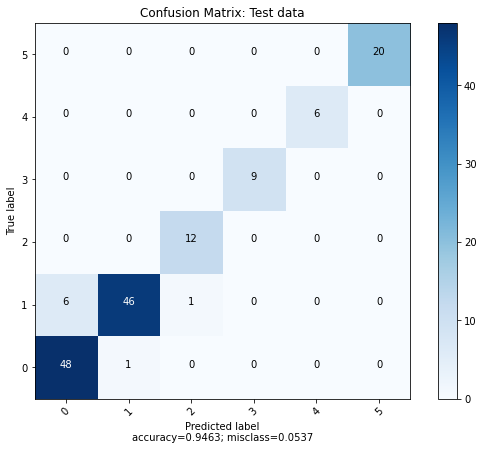

In [15]:
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = model.predict(X_std_np, verbose=0 )
print('log_loss:   ', log_loss(one_hot_y, y_pred, eps=1e-15))

y_true = one_hot_y.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean())
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1:          {f1}', '\n')

target_names = ['class {}'.format(i+1) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['0','1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

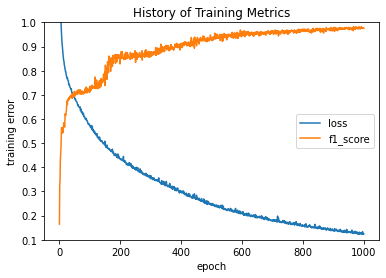

In [16]:
# Training history
plt.figure('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
for k in estimator_ex1.history.keys(): # plot the history of training metrics for each opoch
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.title('History of Training Metrics')
plt.ylim(0.1,1)
plt.show()
#plt.savefig('../Vis/NN_pre-made_training_history.png')

# K-Fold Cross Validation

In [17]:
# Define the network, cost function and minimization method
INPUT = {'inp_dim': X_std_np.shape[1],         
         'n_nod': [100],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': .1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipeline_(**INPUT)

num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(X_std, one_hot_y):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_std_np[train], one_hot_y[train],
                        epochs=1000,
                        verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X_std_np[test], one_hot_y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.9923856258392334; f1_score of 0.44860681891441345
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.0359950065612793; f1_score of 0.6654600501060486
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5934797525405884; f1_score of 0.7176788449287415
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.18094544112682343; f1_score of 0.9054834246635437
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.1654966026544571; f1_score of 0.9346405863761902


In [18]:
print(f'Average Accuracy: {round(sum(acc_per_fold)/len(acc_per_fold),3)}%')

Average Accuracy: 0.734%


In [19]:
print(f'Average Loss: {round(sum(loss_per_fold)/len(loss_per_fold),2)}')

Average Loss: 0.79


# Manual Grid Search

We manually went through the following parameters in all combinations to see which ones would give the highest average accuracy and lowest average loss (The best selected is in bold in each list):<br>
Number of Nodes:  [10, **100**, 200]   <br>
Activation Function:  [**tanh**, sigmoid]    <br>
Learning Rate:  [1, **0.1**, 0.01, 0.001]    <br>
Epochs:  [10, 100, 200, **1000**]  

# Train Model on Optimal Parameters

In [20]:
# Define the network, cost function and minimization method
INPUT = {'inp_dim': X_std_np.shape[1],         
         'n_nod': [100],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
final = pipeline_(**INPUT)

#fit the model
final.fit(X_std_np, one_hot_y, epochs=1000, verbose=0);

# Run Test Data

In [21]:
#Load and prepare the test data
df_test = pd.read_csv(TEST) #test dataframe

attributes = list(df_test.columns)[:-1]

X_test = df_test[attributes].copy() #attributes
y_test = df_test['type'].copy() #true values

for i in range(len(y_test)): #makes labels run 0,1,2,3,4,5, rather than 1,2,3,5,6,7
    if y_test[i] > 4:
        y_test[i] = y_test[i] - 2
    else:
        y_test[i] = y_test[i] - 1
        
X_test = z_score(X_test) #standardise

one_hot_y_test = np.zeros((X_test.shape[0], len(y_test.unique()))) # one hot labels
for i in range(X_test.shape[0]):
    one_hot_y_test[i, y2[i]] = 1


 ########## Result for Test Data ########## 

log_loss:    7.329106158196989
accuracy:    0.27692307692307694 

F1:          0.2794687768371979 

              precision    recall  f1-score   support

     class 1       0.32      0.35      0.33        20
     class 2       0.40      0.40      0.40        20
     class 3       0.20      0.17      0.18         6
     class 4       0.00      0.00      0.00         3
     class 5       0.33      0.20      0.25         5
     class 6       0.12      0.09      0.11        11

    accuracy                           0.28        65
   macro avg       0.23      0.20      0.21        65
weighted avg       0.29      0.28      0.28        65



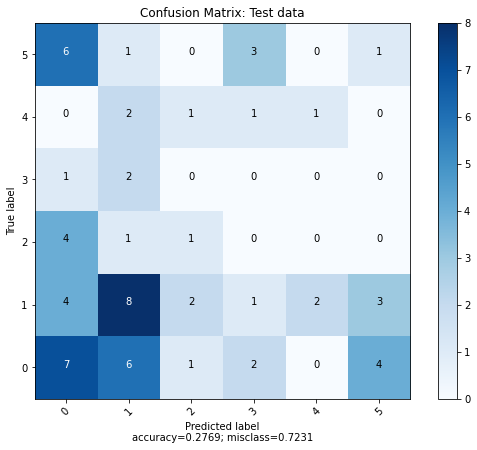

In [22]:
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = final.predict(X_test, verbose=0 )
print('log_loss:   ', log_loss(one_hot_y_test, y_pred, eps=1e-15))

y_true = one_hot_y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean(), '\n')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1:          {f1}', '\n')

target_names = ['class {}'.format(i+1) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['0','1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")

## PCA

In [23]:
pca = PCA(n_components=7) # 99% of the data explained.
pca.fit(X)

X = pd.DataFrame(pca.transform(X))
X = z_score(X)

X_test = pd.DataFrame(pca.transform(X_test))
X_test = z_score(X_test)

In [24]:
# Use K-fold to find optimum model parameters
INPUT = {'inp_dim': X.shape[1],         
         'n_nod': [50],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipeline_(**INPUT)

num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
f1_per_fold = []
loss_per_fold = []
for train, test in kfold.split(X, one_hot_y):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X.iloc[train], one_hot_y[train],
                        epochs=1500,
                        verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X.iloc[test], one_hot_y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    f1_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
print(f'Average F1: {round(sum(f1_per_fold)/len(f1_per_fold),3)}')
print(f'Average Loss: {round(sum(loss_per_fold)/len(loss_per_fold),2)}')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.757181167602539; f1_score of 0.5003418922424316
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1.3919978141784668; f1_score of 0.6946570873260498
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.70925372838974; f1_score of 0.7736842036247253
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.4376763701438904; f1_score of 0.9269005656242371
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.3064556419849396; f1_score of 0.740079402923584
Average F1: 0.727
Average Loss: 0.92


# Manual Grid Search

We manually went through the following parameters in all combinations to see which ones would give the highest average accuracy and lowest average loss (The best selected is in bold in each list):<br>
Number of Nodes:  [10, **50**, 100]   <br>
Learning Rate:  [1, **0.1**, 0.01]    <br>
Epochs:  [10, 100, **1000**, 1500]

# Final Test

In [25]:
# Define the network, cost function and minimization method
INPUT = {'inp_dim': X.shape[1],         
         'n_nod': [50],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
final = pipeline_(**INPUT)

#fit the model
final.fit(X, one_hot_y, epochs=1000, verbose=0);


 ########## Result for Test Data ########## 

log_loss:    5.9674341361253305
accuracy:    0.18461538461538463
F1:          0.1804956778640989 

              precision    recall  f1-score   support

     class 1       0.21      0.30      0.25        20
     class 2       0.24      0.20      0.22        20
     class 3       0.00      0.00      0.00         6
     class 4       0.00      0.00      0.00         3
     class 5       0.33      0.20      0.25         5
     class 6       0.12      0.09      0.11        11

    accuracy                           0.18        65
   macro avg       0.15      0.13      0.14        65
weighted avg       0.19      0.18      0.18        65



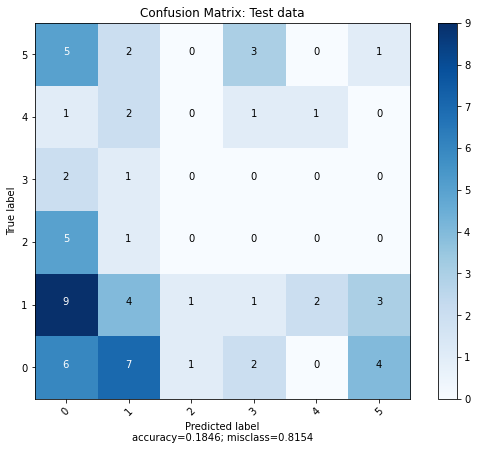

In [26]:
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = final.predict(X_test, verbose=0 )
print('log_loss:   ', log_loss(one_hot_y_test, y_pred, eps=1e-15))

y_true = one_hot_y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean())

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1:          {f1}', '\n')

target_names = ['class {}'.format(i+1) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['0','1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix: Test data")